In [1]:
# Train the model from generated pseudo-spots (for reproducing results in the paper), take STARmap as example.
# starmap_from_spots.json:
# {
#   "sub_name":"starmap_from_spot",
#   "real_st_path": "./data/starmap_spatial.h5ad",
#   "real_location_path": "./data/combined_Locations.txt",
#   "sc_path" : "./data/starmap_sc_rna.h5ad",
#   "gpu_id": 0
# }
!/home/comp/cszrwang/anaconda3/envs/dl_transformer/bin/python main.py --input ./configs/starmap_from_spots.json

Select 207 HVGs
total real SRT for unsupervised training: 1
Generating pseudo-graphs: 100%|###############| 250/250 [00:10<00:00, 23.03it/s]
total graphs of pseudo-spots for pre-training: 250
start training seed1
Using GPU: 0
Directory already exists: ./checkpoints/starmap_from_spot
Epoch 1: 100%|#################################| 1/1 [00:00<00:00, 11.31batch/s]
average_mse_loss: 14.297
Epoch 2: 100%|#################################| 1/1 [00:00<00:00, 11.97batch/s]
average_mse_loss: 6.989
Epoch 3: 100%|#################################| 1/1 [00:00<00:00, 11.33batch/s]
average_mse_loss: 6.480
Epoch 4: 100%|#################################| 1/1 [00:00<00:00, 12.19batch/s]
average_mse_loss: 11.591
Epoch 5: 100%|#################################| 1/1 [00:00<00:00, 12.28batch/s]
average_mse_loss: 11.311
Epoch 6: 100%|#################################| 1/1 [00:00<00:00, 12.26batch/s]
average_mse_loss: 10.684
Epoch 7: 100%|#################################| 1/1 [00:00<00:00, 12.30batch/s]
a

In [2]:
# specify which seed and epoch the pre-trained model has.
!/home/comp/cszrwang/anaconda3/envs/dl_transformer/bin/python test.py --input ./configs/starmap_from_spots.json --seed 1 --epoch 20

Obtain cell types label referring to /home/comp/cszrwang/project/Geneformer_test/STARmap/toy/pseudo_p_6.h5ad
Select 207 HVGs
Directory already exists: ./outputs/starmap_from_spot
Directory already exists: ./figures/starmap_from_spot
Plotting heatmaps...
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Figure(400x800)
Plotting pie charts...
Plotting pie plots:: 100%|####################| 189/189 [00:08<00:00, 23.09it/s]
Figure(476.667x513)


In [3]:
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import pandas as pd
import scanpy as sc
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr,ttest_ind,mannwhitneyu
from sklearn.metrics import mean_squared_error

In [4]:
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm

In [5]:
# read ground truth
gd_results = pd.read_table('/home/comp/cszrwang/results/Deconvolution/results/STARmap/combined_spot_clusters.txt', sep = '\t', header = 0, index_col = 0)
gd_results.columns = ['Astro', 'Endo', 'Excitatory L2/3', 'Excitatory L4', 'Excitatory L5', 'Excitatory L6', 'HPC', 'Micro', 'Npy'
                     , 'Olig', 'Other', 'Inhibitory Pvalb', 'Smc', 'Inhibitory Sst', 'Inhibitory Vip']
gd_results = (gd_results.T/gd_results.sum(axis=1)).T

gd_results = gd_results.drop(columns=['Other','Npy', 'HPC'])
gd_results = gd_results.loc[:,np.unique(gd_results.columns)]

gd_results = gd_results.fillna(0)

gd_loc = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/combined_Locations.txt',sep='\t')

In [8]:
def draw_pie(dist, xpos, ypos, size, colors, ax):

    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()
    i = 0
    for r1, r2 in zip(pie[:-1], pie[1:]):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2, num=100)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])
        ax.scatter([xpos], [ypos], marker=xy, s=size, c=colors[i], edgecolors='none')
        i += 1

    return ax

def plot_frac_results(predict, cell_type_list, coordinates, file_name=None, point_size=1000, size_coefficient=0.0009, if_show=True, color_dict=None):
    
    coordinates.columns = ['coor_X', 'coor_Y']
    labels = cell_type_list
    if color_dict != None:
        colors = []
        for i in cell_type_list:
            colors.append(color_dict[i])
    else:
        if len(labels) <= 10:
            colors = plt.rcParams["axes.prop_cycle"].by_key()['color'][:len(labels)]
        else:
            import matplotlib
            color = plt.get_cmap('rainbow', len(labels))
            colors = []
            for x in color([range(len(labels))][0]):
                colors.append(matplotlib.colors.to_hex(x, keep_alpha=False))
    
    str_len = 0
    for item in cell_type_list:
        str_len = max(str_len, len(item))
    extend_region = str_len/15+1
    
    
    fig, ax = plt.subplots(figsize=(len(coordinates['coor_X'].unique())*point_size*size_coefficient+extend_region, len(coordinates['coor_Y'].unique())*point_size*size_coefficient))
    
    for i in tqdm(range(predict.shape[0]), desc="Plotting pie plots:"):
        ax = draw_pie(predict[i], coordinates['coor_X'].values[i], coordinates['coor_Y'].values[i], 
                                              size=point_size, ax=ax, colors=colors)
        
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')  # Set edge line color of all spines to grey
    
    
    patches = [mpatches.Patch(color=colors[i], label="{:s}".format(labels[i]) ) for i in range(len(colors))]
    fontsize = max(predict.shape[0]/100, 10)
    fontsize = min(fontsize, 30)
    ax.legend(handles=patches, fontsize=fontsize, bbox_to_anchor=(1, 1), loc="upper left")
    plt.axis("equal")
#     plt.edgecolors("lightgrey")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name, 
                    dpi=300, 
#                     bbox_inches='tight'
                   )
    if if_show == True:
        plt.show()
    plt.close('all')
    
    
    
def plot_scatter_by_type(predict, cell_type_list, coordinates, point_size=400, size_coefficient=0.0009, file_path=None, if_show=True):
    
    coordinates.columns = ['coor_X', 'coor_Y']
    
    for i in tqdm(range(len(cell_type_list)), desc="Plotting cell type scatter plot:"):
        
        fig, ax = plt.subplots(figsize=(len(coordinates['coor_X'].unique())*point_size*size_coefficient+1, len(coordinates['coor_Y'].unique())*point_size*size_coefficient))
        cm = plt.cm.get_cmap('Reds')
        ax = plt.scatter(coordinates['coor_X'], coordinates['coor_Y'], s=point_size, vmin=0, vmax=1, c=predict[:, i], cmap=cm)

        cbar = plt.colorbar(ax, fraction=0.05)
        labelsize = max(predict.shape[0]/100, 10)
        labelsize = min(labelsize, 30)
        cbar.ax.tick_params(labelsize=labelsize)
        plt.axis("equal")
        plt.xticks([])
        plt.yticks([])
        plt.xlim(coordinates['coor_X'].min()-0.5, coordinates['coor_X'].max()+0.5)
        plt.ylim(coordinates['coor_Y'].min()-0.5, coordinates['coor_Y'].max()+0.5)
        plt.tight_layout()
        if file_path != None:
            name = cell_type_list[i].replace('/', '_')
            plt.savefig(file_path+'/{}.jpg'.format(name), dpi=300, bbox_inches='tight')
        if if_show == True:
            plt.show()
        plt.close('all')

In [9]:
color_dict = {'Astro': '#FCCDE5', 'Endo': '#D9D9D9', 'Excitatory L2/3': '#FFCC00', 'Excitatory L4': '#FFFF66',
             'Excitatory L5': '#99CC00', 'Excitatory L6': '#CCFFFF', 'Inhibitory Pvalb': '#666699', 'Inhibitory Sst': '#666633', 'Inhibitory Vip': '#993366',
             'Micro': '#333333', 'Olig': '#F0027F', 'Smc': '#666666', 'Other': '#BF5B17'}

In [10]:
harmodecon_results = pd.read_csv("./outputs/starmap_from_spot/mean_out_starmap_from_spot_20_seed1.model.csv")
harmodecon_results = harmodecon_results.loc[:,np.unique(harmodecon_results.columns)].fillna(0)
harmodecon_results['Other'] = harmodecon_results['Other'] + harmodecon_results['Inhibitory Other'] + harmodecon_results['Neuron Other']
harmodecon_results = harmodecon_results.drop(columns=['Neuron Other','Inhibitory Other'])

In [11]:
output_dir = '/home/comp/cszrwang/results/Deconvolution/results/STARmap/Figures'
cell_type_list = harmodecon_results.columns.to_list()
coordinates = gd_loc[['x', 'y']]

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

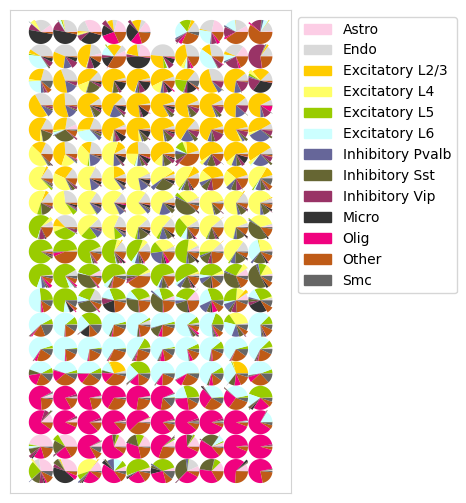

In [12]:
plot_frac_results(np.array(harmodecon_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/harmodecon_results_pie_plot.jpg', color_dict=color_dict)

In [13]:
gd_results = pd.read_table('/home/comp/cszrwang/results/Deconvolution/results/STARmap/combined_spot_clusters.txt', sep = '\t', header = 0, index_col = 0)
gd_results.columns = ['Astro', 'Endo', 'Excitatory L2/3', 'Excitatory L4', 'Excitatory L5', 'Excitatory L6', 'HPC', 'Micro', 'Npy'
                     , 'Olig', 'Other', 'Inhibitory Pvalb', 'Smc', 'Inhibitory Sst', 'Inhibitory Vip']
gd_results = (gd_results.T/gd_results.sum(axis=1)).T

gd_results['Other'] = gd_results['Other'] + gd_results['Npy'] + gd_results['HPC']
gd_results = gd_results.drop(columns=['Npy', 'HPC'])
gd_results = gd_results.loc[:,np.unique(gd_results.columns)]

gd_results = gd_results.fillna(0)

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

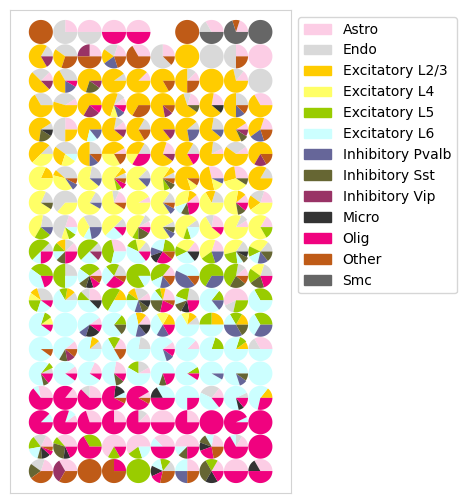

In [14]:
plot_frac_results(np.array(gd_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/gd_results_pie_plot.jpg', color_dict=color_dict)